In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Функции, использующиеся при обработке данных


# Функция для расчёта статистических параметров: iqr, квартили, границы выбросов, количество выбросов
# Передаём на вход столбец DataFrame
def quantile_info(column):
    # Перцентили и IQR
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    iqr = perc75 - perc25
    # Границы выбросов
    low = perc25 - 1.5*iqr
    high = perc75 + 1.5*iqr
    # Количество выбросов в столбце
    count_low = (column[(column<low)]).count()
    count_high = (column[(column>high)]).count()
    # Печатаем вычисленные значения на экране    
    print(
        f'25-й перцентиль: {perc25}\n',
        f'75-й перцентиль: {perc75}\n',
        f'IQR: {iqr}\n',
        f'Границы выбросов: [{low}, {high}]\n',
        f'Количество выбросов вниз: {count_low}\n',
        f'Количество выбросов вверх: {count_high}',
        sep='')

    
# Функция для замены выбросов медианным значением
def change_on_median(column):
    # Перцентили и IQR
    perc25 = column.quantile(0.25)
    perc50 = column.quantile(0.5)
    perc75 = column.quantile(0.75)
    iqr = perc75 - perc25
    # Границы выбросов
    low = perc25 - 1.5*iqr
    high = perc75 + 1.5*iqr
    
    return column.apply(lambda x: perc50 if (x < low) | (x > high) else x)


# Функция, выводящая на экран график ROC_AUC
def print_roc_auc(val, pred):
    fpr, tpr, threshold = roc_curve(val, pred)
    roc_auc = roc_auc_score(val, pred)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    
# Функция, выводящая на экран значения метрик логистической регрессии
def print_metrics(val, pred, acc=0):
    # Выбираем, печатать ли метрику accuracy
    if acc == 1:
        print('accuracy:', '%0.4f' %accuracy_score(val, pred))
        
    print('balanced_accuracy:', '%0.4f' %balanced_accuracy_score(val, pred))
    print('precision_score:', '%0.4f' %precision_score(val, pred))
    print('recall_score:', '%0.4f' %recall_score(val, pred))
    print('f1_score:', '%0.4f' %f1_score(val, pred))

## Загрузка начальных данных

In [3]:
# Загружаем таблицу c данными клиентов банка
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
# Загружаем данные для обучения модели
train = pd.read_csv(DATA_DIR+'/train.csv')
# Загружаем данные для теста модели
test = pd.read_csv(DATA_DIR+'/test.csv')
# Загружаем файл с итоговыми данными
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
# описание данных

# client_id - идентификатор клиента
# education - уровень образования
# sex - пол заемщика
# age - возраст заемщика
# car - флаг наличия автомобиля
# car_type - флаг автомобиля иномарки
# deсline_app_cnt - количество отказанных прошлых заявок
# good_work - флаг наличия “хорошей” работы
# bki_request_cnt - количество запросов в БКИ
# home_address - категоризатор домашнего адреса
# work_address - категоризатор рабочего адреса
# income - доход заемщика
# foreign_passport - наличие загранпаспорта
# sna - связь заемщика с клиентами банка
# first_time - давность наличия информации о заемщике
# score_bki - скоринговый балл по данным из БКИ
# region_rating - рейтинг региона
# app_date - дата подачи заявки
# default - флаг дефолта по кредиту

In [5]:
# Смотрим исходные данные
display(train.head(10))
display(train.info())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
5,41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.032257,0,50,1,1,15000,2,3,N,0
6,28436,04FEB2014,SCH,M,39,N,N,0,0,-2.225004,0,60,1,2,28000,1,1,N,0
7,68769,17MAR2014,SCH,F,39,N,N,0,0,-1.522739,1,50,2,3,45000,3,3,N,0
8,38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
9,4496,10JAN2014,UGR,F,54,N,N,0,0,-2.695176,1,50,2,3,24000,1,3,N,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

In [6]:
display(test.head(10))
display(test.info())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N
5,99881,17APR2014,SCH,F,55,N,N,0,0,-1.740224,7,50,3,3,30000,2,1,N
6,26630,02FEB2014,SCH,F,30,N,N,3,0,-1.387847,5,60,1,2,11000,4,3,N
7,79934,28MAR2014,GRD,M,41,Y,Y,0,0,-3.066047,3,60,1,3,80000,4,1,N
8,16605,23JAN2014,GRD,M,34,N,N,0,0,-3.117086,0,80,2,3,5000,1,2,N
9,105449,24APR2014,UGR,M,28,Y,Y,0,0,-2.185172,0,80,2,3,80000,1,3,Y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

In [7]:
display(sample_submission.head(10))
display(sample_submission.info())

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
5,175,0.311599
6,57558,0.584807
7,88407,0.815792
8,79183,0.325037
9,69300,0.094011


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


None

In [8]:
# Для корректной обработки признаков объединяем обучающую и тестовую выборки в один датасет
train['sample'] = 1 # помечаем, где обучающая выборка
test['sample'] = 0 # помечаем, где тестовая выборка
# в тесте у нас нет значения default, мы его должны предсказать, 
# поэтому пока заполним произвольными значениями.
# Пусть каждый седьмой клиент имеет default=1
test['default'] = test['client_id'].apply(lambda x: 1 if x%7 == 0 else 0) 

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [9]:
# Информация по объединённому датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Теперь на основе этих данных построим наивную модель логистической регрессии, для понимания, какого результата можно добиться с минимальной обработкой данных.

## Обработка данных для наивной модели

In [10]:
# Скопируем датасет
data_naiv = data.copy()

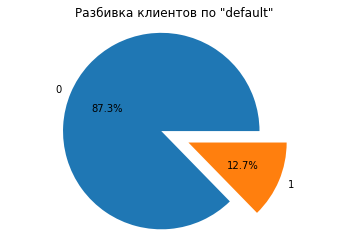

In [11]:
# В первую очередь посмотрим распределение целевой переменной default в обучающей выборке:
labels = train.default.value_counts().index
values = train.default.value_counts().values

plt.title('Разбивка клиентов по "default"')
plt.pie(values, labels=labels, explode=[0.3, 0], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Как видно, клиентов с дефолтом значительно меньше, чем клиентов без дефолта. Поэтому в дальнейшем при обучении модели нужно будет применять методы для несбалансированных классов.

In [12]:
# Смотрим на количество пропусков по столбцам
data_naiv.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

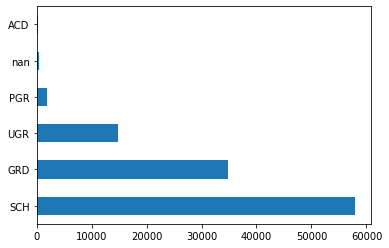

In [13]:
# Как мы видим, пропуски встречаются только в информации об образовании клиентов.
# Посмотрим на признак поближе.
data_naiv['education'].value_counts(dropna=False).plot.barh()

plt.show()

Что значат уровни образования:

SCH - school - те, у кого среднее образование (только школа).

UGR - undergraduate - бакалавры.

GRD - магистры

PGR - postgraduate - учёная степень PhD (кандидаты наук)

ACD - высший уровень.

Пропусков немного относительно общего количества записей (~0.4%), поэтому присоединим их 
к самой многочисленной категории SCH.

In [14]:
data_naiv['education'] = data_naiv['education'].fillna('SCH')
# Проверяем количество пропусков по столбцам
data_naiv.isna().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [15]:
# Категориальные и числовые признаки обрабатываются по-разному.
# Посмотрим, к каким категориям какие признаки относятся.
for a in data_naiv.columns:
    k = data_naiv[a].nunique()
    print(f'Количество значений признаков в столбце {a}: {k}')
    if a == 'sex':
        print('(В современном безумном мире мы должны проверить)')
    print(f'Тип значений признаков в столбце {a}: {data_naiv[a].dtypes}\n\n')
    

Количество значений признаков в столбце client_id: 110148
Тип значений признаков в столбце client_id: int64


Количество значений признаков в столбце app_date: 120
Тип значений признаков в столбце app_date: object


Количество значений признаков в столбце education: 5
Тип значений признаков в столбце education: object


Количество значений признаков в столбце sex: 2
(В современном безумном мире мы должны проверить)
Тип значений признаков в столбце sex: object


Количество значений признаков в столбце age: 52
Тип значений признаков в столбце age: int64


Количество значений признаков в столбце car: 2
Тип значений признаков в столбце car: object


Количество значений признаков в столбце car_type: 2
Тип значений признаков в столбце car_type: object


Количество значений признаков в столбце decline_app_cnt: 24
Тип значений признаков в столбце decline_app_cnt: int64


Количество значений признаков в столбце good_work: 2
Тип значений признаков в столбце good_work: int64


Количество значений

Таким образом, исходя из типа данных и их описания, мы можем разделить признаки на категории следующим образом:

- категориальные - education, region_rating, home_address, work_address, sna, first_time
- бинарные - sex, car, car_type, good_work, foreign_passport
- числовые - age, decline_app_cnt, score_bki, bki_request_cnt, income

Отдельный случай со столбцом app_date, так как там содержится дата. В наивной модели не будем его учитывать

In [16]:
# Создадим списки колонок по категориям для удобства работы.
# Столбцы default и client_id не включаем, так как первый - целевая переменная,
# а второй - просто номер клиента
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# Удаляем столбец app_date и sample
data_naiv = data_naiv.drop(['app_date', 'sample'], axis=1)

In [17]:
# Для начала переведём бинарные признаки в числа с помощью LabelEncoder
label_encoder = LabelEncoder()

for b in bin_cols:
    data_naiv[b] = label_encoder.fit_transform(data_naiv[b])
    
# убедимся в преобразовании    
data_naiv.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,74835,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0
1,17527,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0
2,75683,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0
3,26883,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0
4,28862,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0


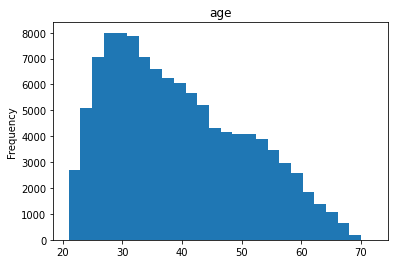

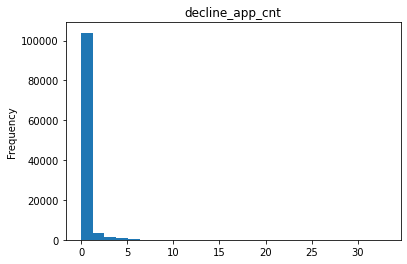

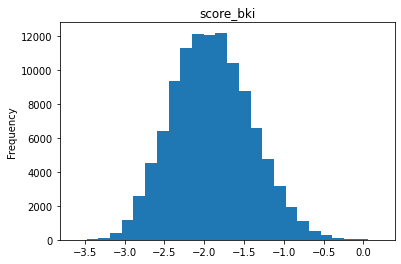

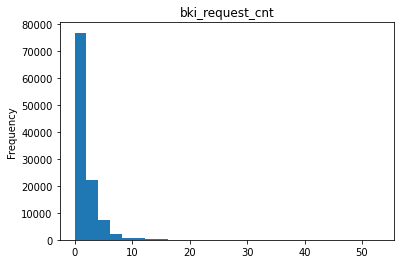

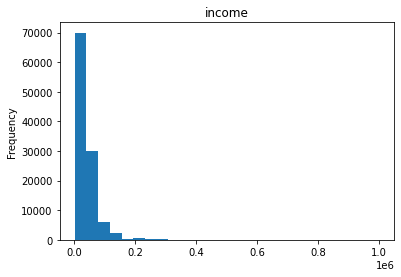

In [18]:
# Посмотрим на распределение числовых переменных:
for c in num_cols:
    data_naiv[c].plot.hist(bins=26)
    plt.title(c)
    plt.show()

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост.

Для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда мы сможем избежать чувствительности к сильным отклонениям в суммах у линейных моделей.

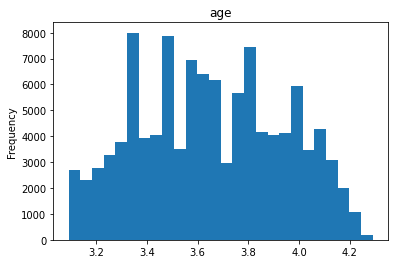

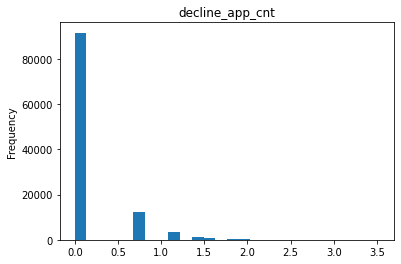

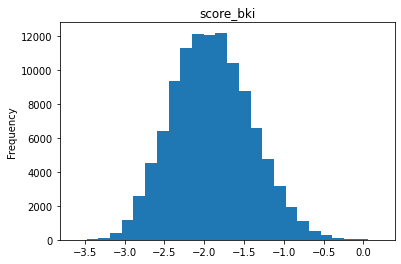

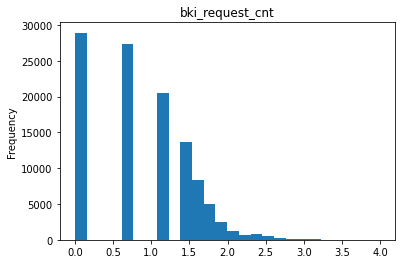

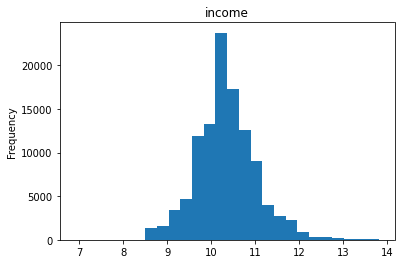

In [19]:
# прологарифмируем все числовые столбцы, кроме score_bki
for d in num_cols:
    data_naiv[d] = data_naiv[d].apply(lambda x: np.log(x + 1) if d != 'score_bki' else x)
    data_naiv[d].plot.hist(bins=26)
    plt.title(d)
    plt.show()


In [20]:
# Закодируем категориальные признаки с помощью OneHotEncoding
X_naiv_cat =  pd.get_dummies(data_naiv, columns=cat_cols).values
X_naiv_cat.shape

(110148, 38)

In [21]:
# Объединим стандартизованные числовые, бинарные и закодированные категориальные
# переменные в одно признаковое пространство, разделив при этом признаки
# и целевую переменную.
X_naiv = np.hstack([data_naiv[num_cols].values, data_naiv[bin_cols].values, X_naiv_cat])
Y_naiv = data_naiv['default'].values

In [22]:
# Разделим данные для обучения на тренировочную и тестовую выборки следующим образом:
X_train_naiv, X_test_naiv, Y_train_naiv, Y_test_naiv = train_test_split(X_naiv, Y_naiv, test_size=0.20, random_state=42)

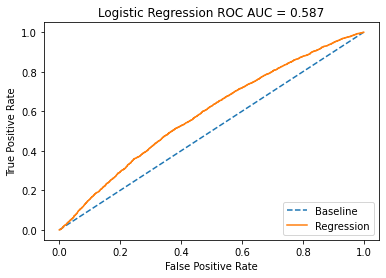

In [23]:
# Обучаем модель на стандартных настройках логистической регрессии
# Логистическая регрессия
model_naiv = LogisticRegression(max_iter=5000)
model_naiv.fit(X_train_naiv, Y_train_naiv)

probs_naiv = model_naiv.predict_proba(X_test_naiv)
Y_pred_naiv = model_naiv.predict(X_test_naiv)
probs_naiv = probs_naiv[:,1]

# Выводим на экран график roc_auc
print_roc_auc(Y_test_naiv, probs_naiv)

In [24]:
# Матрица ошибок для нашего алгоритма
print(confusion_matrix(Y_test_naiv, Y_pred_naiv))

[[19123     0]
 [ 2907     0]]


Наша наивная модель все примеры причислила к классу default=0. Что вполне закономерно для такого разбаланса классов.

Посмотрим остальные метрики качества для логистической регрессии

In [25]:
print_metrics(Y_test_naiv, Y_pred_naiv, acc=1)

accuracy: 0.8680
balanced_accuracy: 0.5000
precision_score: 0.0000
recall_score: 0.0000
f1_score: 0.0000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Так как наша модель не дала значений TN и FN, метрики precision, recall и f1 не посчитались.
А вот метрика accuracy показала очень хорошее значение, что лишний раз подтверждает, что её нельзя использовать в случае несбалансированных классов. Поэтому в дальнейшем будем смотреть характеристику balanced_accuracy, которая гораздо лучше подходит для таких случаев.

Как видим, наивная модель не сильно отличается от случайного угадывания. Для улучшения характеристик модели необходимо проводить исследование и обработку данных.

## Анализ данных

In [26]:
# Вспоним, как выглядит объединённый датасет
display(data.head(10))
display(data.info())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
5,99881,17APR2014,SCH,F,55,N,N,0,0,-1.740224,7,50,3,3,30000,2,1,N,0,0
6,26630,02FEB2014,SCH,F,30,N,N,3,0,-1.387847,5,60,1,2,11000,4,3,N,0,0
7,79934,28MAR2014,GRD,M,41,Y,Y,0,0,-3.066047,3,60,1,3,80000,4,1,N,0,0
8,16605,23JAN2014,GRD,M,34,N,N,0,0,-3.117086,0,80,2,3,5000,1,2,N,0,0
9,105449,24APR2014,UGR,M,28,Y,Y,0,0,-2.185172,0,80,2,3,80000,1,3,Y,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

**Признак client_id**

In [27]:
# Посмотрим, сколько значений в этом столбце
data['client_id'].nunique()

110148

Получается, здесь просто порядковый номер клиента. Никакой обработки для этого столбца не предполагается.

**Признак app_date**

In [28]:
# Здесь содержится дата заявки клиента в виде строки. Преобразуем эти данные в формат даты
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'].value_counts()

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

На основе даты создадим новые признаки.

In [29]:
# Посмотрим самую раннюю и самую позднюю даты в этом признаке
print(f"Самая ранняя дата: {data['app_date'].min()}")
print(f"Самая поздняя дата: {data['app_date'].max()}")

Самая ранняя дата: 2014-01-01 00:00:00
Самая поздняя дата: 2014-04-30 00:00:00


Все даты в 2014 году. Поэтому признак с годом создавать не будем, создадим следующие признаки:

номер месяца, номер дня недели, номер дня месяца, номер дня года

In [30]:
data['month'] = data['app_date'].apply(lambda t: t.month)
data['day'] = data['app_date'].apply(lambda t: t.day)
data['weekday'] = data['app_date'].apply(lambda t: t.isoweekday())
data['yearday'] = data['app_date'].apply(lambda t: t.dayofyear)

# И удалим признак app_date
data = data.drop(['app_date'], axis=1)

In [31]:
# Добавим вновь созданные признаки в списки колонок для облегчения работы
# 'weekday' к категориальным
cat_cols.append('weekday')

# Остальные к числовым
num_cols.append('month')
num_cols.append('day')
num_cols.append('yearday')

### Теперь обработаем числовые признаки
К числовым мы отнесли следующие признаки:

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

Как мы помним, почти все признаки имеют сильное смещение. Поэтому для нормализации сначала прологарифмируем их, потом будем искать выбросы.

**Признак age**

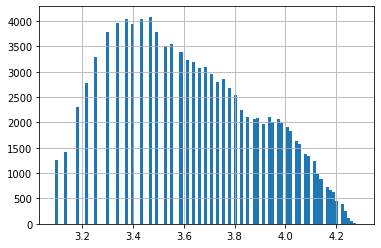

25-й перцентиль: 3.4339872044851463
75-й перцентиль: 3.8918202981106265
IQR: 0.4578330936254802
Границы выбросов: [2.7472375640469258, 4.5785699385488465]
Количество выбросов вниз: 0
Количество выбросов вверх: 0


In [32]:
data['age'] = data['age'].apply(lambda x: np.log(x + 1))

data['age'].hist(bins=100)
plt.show()

quantile_info(data['age'])

Выбросы отсутствуют.

**Признак decline_app_cnt**

In [33]:
# Сначала посмотрим на значения признака
data['decline_app_cnt'].value_counts().head(10)

0    91471
1    12500
2     3622
3     1365
4      606
5      255
6      156
7       58
8       37
9       29
Name: decline_app_cnt, dtype: int64

Как видим, подавляющее количество клиентов не получало отказов по предыдущим заявкам.
Поэтому на основе этого признака создадим бинарный, показывающий, получал ли человек отказ ранее.

In [34]:
data['decline_app_bin'] = data['decline_app_cnt'].apply(lambda g: int(g != 0))

# Добавляем признак в список бинарных
bin_cols.append('decline_app_bin')

Теперь создадим ещё один признак, прологарифмировав значения признака.
Сам признак оставим без изменений, потом создадим на его основе ещё пару признаков.

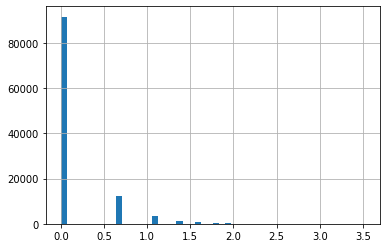

25-й перцентиль: 0.0
75-й перцентиль: 0.0
IQR: 0.0
Границы выбросов: [0.0, 0.0]
Количество выбросов вниз: 0
Количество выбросов вверх: 18677


In [35]:
data['decline_app_log'] = data['decline_app_cnt'].apply(lambda x: np.log(x + 1))

data['decline_app_log'].hist(bins=50)
plt.show()

quantile_info(data['decline_app_log'])

# Добавляем новый признак в список числовых
num_cols.append('decline_app_log')

Выбросы оставим, потому что иначе в столбце останутся одни нулевые значения

**Признак bki_request_cnt**

In [36]:
# Сначала посмотрим на значения признака
data['bki_request_cnt'].value_counts().head(10)

0    28908
1    27295
2    20481
3    13670
4     8406
5     4960
6     2500
7     1292
8      735
9      459
Name: bki_request_cnt, dtype: int64

Разница в количестве ненулевых и нулевых значений не такая большая, как в признаке decline_app_cnt.
Но, тем не менее, на основе этого признака создадим бинарный, показывающий, обращался ли человек в БКИ ранее. Может, это будет полезно для нашей модели.

In [37]:
data['bki_request_bin'] = data['bki_request_cnt'].apply(lambda h: int(h != 0))

# Добавляем признак в список бинарных
bin_cols.append('bki_request_bin')

data['bki_request_bin'].value_counts()

1    81240
0    28908
Name: bki_request_bin, dtype: int64

Теперь создадим ещё один признак, прологарифмировав значения признака.
Сам признак оставим без изменений, потом создадим на его основе ещё пару признаков.

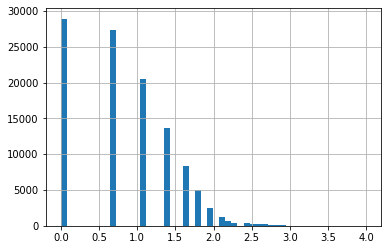

25-й перцентиль: 0.0
75-й перцентиль: 1.3862943611198906
IQR: 1.3862943611198906
Границы выбросов: [-2.0794415416798357, 3.465735902799726]
Количество выбросов вниз: 0
Количество выбросов вверх: 15


In [38]:
data['bki_request_log'] = data['bki_request_cnt'].apply(lambda x: np.log(x + 1))

data['bki_request_log'].hist(bins=50)
plt.show()

quantile_info(data['bki_request_log'])

In [39]:
# В столбце содержится 15 выбросов. Заменим их на меданные значения
data['bki_request_log'] = change_on_median(data['bki_request_log'])

# Добавляем новый признак в список числовых
num_cols.append('bki_request_log')

**Признак score_bki**

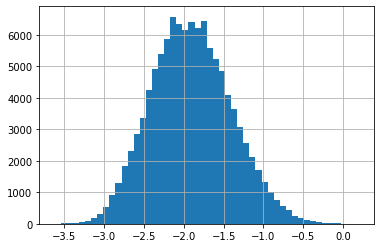

25-й перцентиль: -2.2604336700000003
75-й перцентиль: -1.5678881525
IQR: 0.6925455175000004
Границы выбросов: [-3.299251946250001, -0.5290698762499992]
Количество выбросов вниз: 82
Количество выбросов вверх: 436


In [40]:
# Посмотрим на характеристики распределения
data['score_bki'].hist(bins=50)
plt.show()

quantile_info(data['score_bki'])

In [41]:
# Создадим признак, заменив выбросы на медианное значение
data['score_bki_clear'] = change_on_median(data['score_bki'])

# Добавляем новый признак в список числовых
num_cols.append('score_bki_clear')

**Признак income**

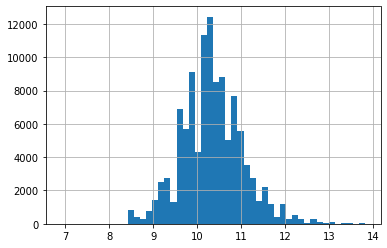

25-й перцентиль: 9.90353755128617
75-й перцентиль: 10.778977123006351
IQR: 0.8754395717201806
Границы выбросов: [8.590378193705899, 12.092136480586621]
Количество выбросов вниз: 875
Количество выбросов вверх: 1734


In [42]:
# Прологарифмируем и посмотрим наличие выбросов
data['income'] = data['income'].apply(lambda x: np.log(x + 1))
data['income'].hist(bins=50)
plt.show()

quantile_info(data['income'])

In [43]:
# Заменим все выбросы на медианное значение
data['income'] = change_on_median(data['income'])

In [44]:
# создание признаков из информации в БКИ
data['uno'] = (data['bki_request_cnt'] - data['decline_app_cnt']) * data['score_bki']
data['uno_log'] = (data['bki_request_log'] - data['decline_app_log']) * data['score_bki_clear']

data['dos'] = data['bki_request_cnt'] * data['decline_app_cnt'] * data['score_bki']
data['dos_log'] = data['bki_request_log'] * data['decline_app_log'] * data['score_bki_clear']

# Добавляем новые признаки в список числовых
num_cols.append('uno')
num_cols.append('uno_log')
num_cols.append('dos')
num_cols.append('dos_log')

### Теперь обработаем категориальные признаки
Изначально к категориальным мы отнесли следующие признаки:

cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

In [45]:
# Посмотрим на них поближе:
data[cat_cols].head(10)

,education,region_rating,home_address,work_address,sna,first_time,weekday
0,GRD,50,1,2,1,4,6
1,SCH,50,1,2,4,3,5
2,UGR,50,1,2,1,3,7
3,SCH,40,1,2,1,3,1
4,GRD,80,2,3,1,3,2
5,SCH,50,3,3,2,1,4
6,SCH,60,1,2,4,3,7
7,GRD,60,1,3,4,1,5
8,GRD,80,2,3,1,2,4
9,UGR,80,2,3,1,3,4


In [46]:
# Как мы помним, в столбце education содержатся пропуски.
# Заполним их тем же способом, что и для наивной модели.
data['education'] = data['education'].fillna('SCH')

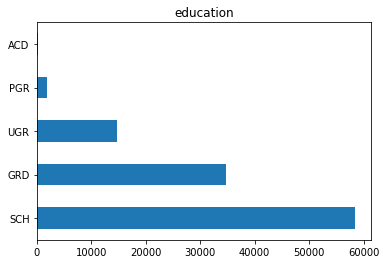

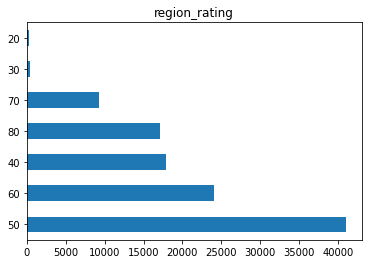

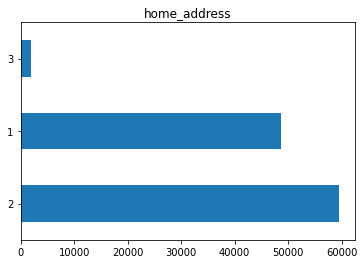

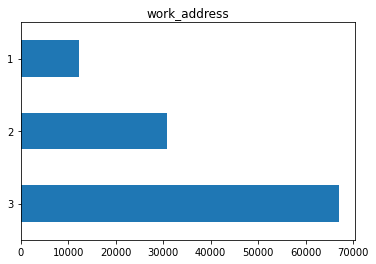

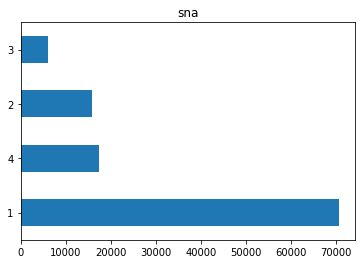

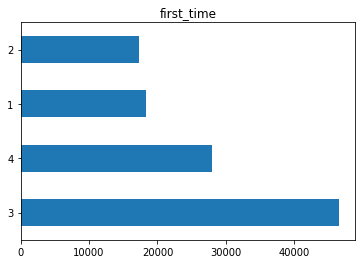

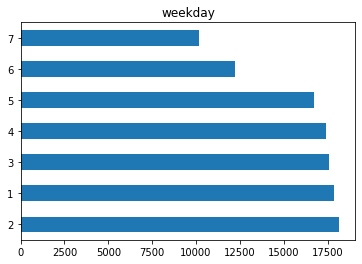

In [47]:
# Посмотрим распределения категориальных переменных в выборке:
for e in cat_cols:
    data[e].value_counts(dropna=False).plot.barh()
    plt.title(e)
    plt.show()

К сожалению, без дополнительной информации мы не можем сделать выводов о содержании данных столбцов, поэтому оставим эти данные без обработки. Позже закодируем их с помощью OneHotEncoder.

### Теперь обработаем бинарные признаки
К бинарным мы отнесли следующие признаки:

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [48]:
# Посмотрим на них поближе:
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport,decline_app_bin,bki_request_bin
0,M,Y,Y,0,N,0,1
1,F,N,N,0,N,1,1
2,M,Y,Y,0,Y,0,1
3,M,N,N,0,N,0,1
4,F,N,N,0,N,0,0


In [49]:
# Переведём бинарные признаки в числа с помощью LabelEncoder
label_encoder = LabelEncoder()

for f in bin_cols:
    data[f] = label_encoder.fit_transform(data[f])
    
# убедимся в преобразовании    
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport,decline_app_bin,bki_request_bin
0,1,1,1,0,0,0,1
1,0,0,0,0,0,1,1
2,1,1,1,0,1,0,1
3,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0


Объединим признаки car и car_type в один, категориальный:

0 - нет машины

1 - есть отечественная машина

2 - есть иномарка

In [50]:
data['car'] = data['car'] + data['car_type']
data.drop('car_type', axis=1, inplace=True)
# Удалим признак из бинарных и переведём его в категориальные
bin_cols.remove('car_type')
bin_cols.remove('car')
cat_cols.append('car')

# Теперь оценим важность признаков и посмотрим матрицу корреляций

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. mutual_info_classif сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями, поэтому необходимо преобразовать столбец education к целочисленным значениям

In [51]:
edu_dict = {'ACD':0, 'PGR':1, 'UGR':2, 'GRD':3, 'SCH':4}
data['education'] = data['education'].apply(lambda x: edu_dict[x])
data['education'].value_counts(dropna=False)

4    58476
3    34768
2    14748
1     1865
0      291
Name: education, dtype: int64

<AxesSubplot:>

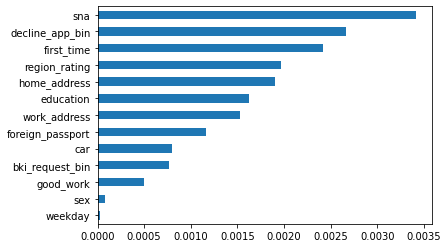

In [52]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

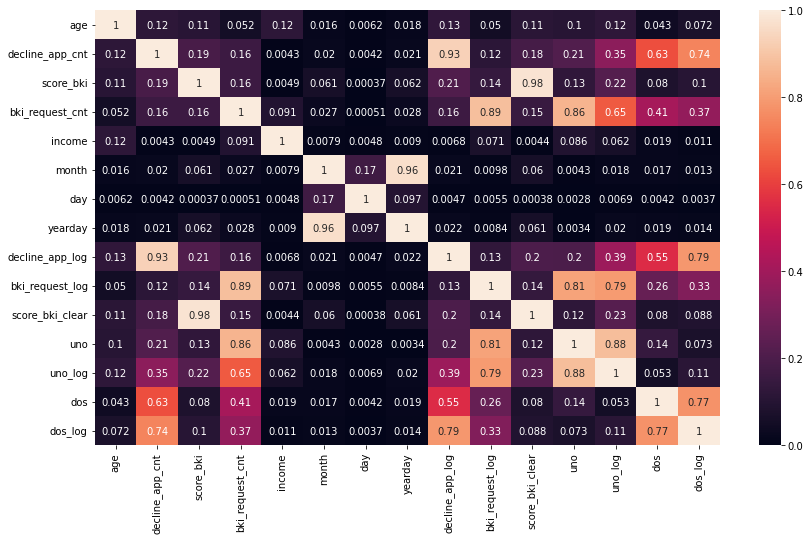

In [53]:
# Cильная корреляция между переменными вредна для
# линейных моделей из-за неустойчивости полученных оценок.
# Оценим корреляцию Пирсона для численных переменных:
plt.figure(figsize=(14, 8))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)
plt.show()

# Критерием для удаления признаков будем считать корреляцию выше 0,7

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

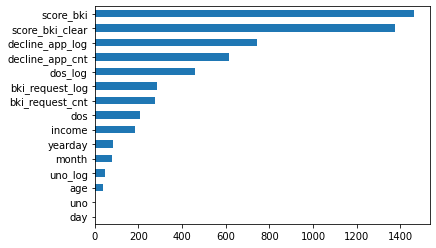

In [54]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

На основании матрицы корреляций и оценки важности признаков удалим из датасета следующие столбцы:

weekday, uno,dos_log, uno_log, day, month, bki_request_cnt, decline_app_cnt, score_bki


In [55]:
data.drop(['weekday', 'uno', 'dos_log', 'uno_log', 'day', 'month', 'bki_request_cnt', 'decline_app_cnt', 'score_bki'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   region_rating     110148 non-null  int64  
 7   home_address      110148 non-null  int64  
 8   work_address      110148 non-null  int64  
 9   income            110148 non-null  float64
 10  sna               110148 non-null  int64  
 11  first_time        110148 non-null  int64  
 12  foreign_passport  110148 non-null  int64  
 13  sample            110148 non-null  int64  
 14  default           110148 non-null  int64  
 15  yearday           110148 non-null  int64  
 16  decline_app_bin   11

In [56]:
num_cols.remove('uno')
num_cols.remove('uno_log')
num_cols.remove('dos_log')
num_cols.remove('day')
num_cols.remove('month')
num_cols.remove('bki_request_cnt')
num_cols.remove('decline_app_cnt')
num_cols.remove('score_bki')
cat_cols.remove('weekday')

In [57]:
# Закодируем категориальные и бинарные признаки с помощью OneHotEncoding
data =  pd.get_dummies(data, columns=cat_cols+bin_cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   age                 110148 non-null  float64
 2   income              110148 non-null  float64
 3   sample              110148 non-null  int64  
 4   default             110148 non-null  int64  
 5   yearday             110148 non-null  int64  
 6   decline_app_log     110148 non-null  float64
 7   bki_request_log     110148 non-null  float64
 8   score_bki_clear     110148 non-null  float64
 9   dos                 110148 non-null  float64
 10  education_0         110148 non-null  uint8  
 11  education_1         110148 non-null  uint8  
 12  education_2         110148 non-null  uint8  
 13  education_3         110148 non-null  uint8  
 14  education_4         110148 non-null  uint8  
 15  region_rating_20    110148 non-nul

In [58]:
# Выделим в выборке обучающую часть и тестовую по признаку sample
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим обучающую выборку на обучающую и валидационную части, для проверки разных моделей. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submission на kaggle.
Заодно стандартизируем числовые признаки.**

In [59]:
# Функция, разделяющая датасет на обучающую и валидационную части со стандартизацией числовых признаков
# Принимает на вход DataFrame, возвращает 4 массива numpy
y = train_data['default'].copy()
x = train_data.copy().drop(['default'], axis=1)
    
x_train_pd, x_valid_pd, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    
# Cтандартизируем числовые признаки
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train_pd[num_cols].values)
x_valid_num = scaler.transform(x_valid_pd[num_cols].values)
    
# И соберём все признаки в numpy array
X_train = np.hstack([x_train_num, x_train_pd.drop(columns=num_cols).values])
X_valid = np.hstack([x_valid_num, x_valid_pd.drop(columns=num_cols).values])
    
Y_train = y_train.values
Y_valid = y_valid.values


In [60]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((59039, 46), (14760, 46), (59039,), (14760,))

# Модели логистической регрессии

### Модель логистической регрессии с параметрами по умолчанию

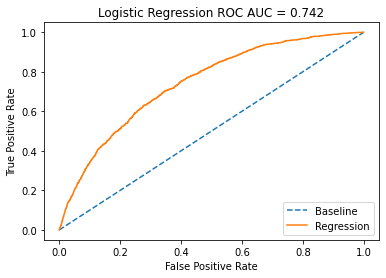

In [61]:
# Обучаем модель на стандартных настройках логистической регрессии
model_simple = LogisticRegression(max_iter=5000)
model_simple.fit(X_train, Y_train)

probs_simple = model_simple.predict_proba(X_valid)
Y_pred_simple = model_simple.predict(X_valid)
probs_simple = probs_simple[:,1]

# Выводим на экран график roc_auc
print_roc_auc(Y_valid, probs_simple)

In [62]:
confusion_matrix(Y_valid, Y_pred_simple)

array([[12877,    56],
       [ 1793,    34]])

In [63]:
# Как видим, новая модель уже пытается различать классы.
# Посмотрим остальные метрики качества модели
print_metrics(Y_valid, Y_pred_simple)

balanced_accuracy: 0.5071
precision_score: 0.3778
recall_score: 0.0186
f1_score: 0.0355


Метрики качества очень плохи. Вспомним, что у нас несбалансированные классы: значений default=1 гораздо меньше, чем default=0. Построим новую модель с балансировкой классов

### Модель логистической регрессии с балансировкой классов

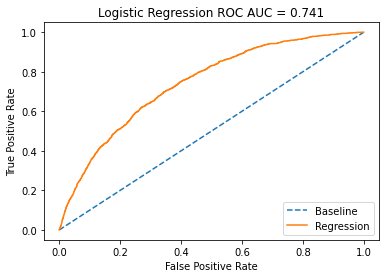

In [64]:
# Обучаем модель логистической регрессии 
model_balance = LogisticRegression(class_weight='balanced', solver='liblinear',max_iter=5000)
model_balance.fit(X_train, Y_train)
probs_balance = model_balance.predict_proba(X_valid)
Y_pred_balance = model_balance.predict(X_valid)

probs_balance = probs_balance[:,1]


fpr, tpr, threshold = roc_curve(Y_valid, probs_balance)
roc_auc = roc_auc_score(Y_valid, probs_balance)

# Выводим на экран график roc_auc
print_roc_auc(Y_valid, probs_balance)

In [65]:
confusion_matrix(Y_valid, Y_pred_balance)

array([[8616, 4317],
       [ 580, 1247]])

In [66]:
# Судя по матрице ошибок, новая модель работает лучше.
# Посмотрим другие метрики качества нашей модели
print_metrics(Y_valid, Y_pred_balance)

balanced_accuracy: 0.6744
precision_score: 0.2241
recall_score: 0.6825
f1_score: 0.3374


Действительно, метрики качества показали существенный рост.

Однако попробуем ещё один способ балансировки классов - undersampling

# Модель с undersampling

In [67]:
#Разделим обучающую выборку на обучающую и валидационную
train_u, valid_u = train_test_split(train_data, test_size=0.20, random_state=42)
train_u.shape, valid_u.shape

((59039, 47), (14760, 47))

Сравняем количество классов в обучающей выборке, удалив большое количество примеров с default=0

In [68]:
train_under_1 = train_u[train_u['default'] == 1].copy()
count_1 = len(train_under_1)

train_under_0 = train_u[train_u['default'] == 0].iloc[:count_1,:].copy()

train_under = pd.concat([train_under_1, train_under_0])

# Проверим количество классов
train_under['default'].value_counts()

1    7545
0    7545
Name: default, dtype: int64

In [69]:
# Выделим из выборок признаки и целевую переменную
X_train_under_pd = train_under.drop(['default'], axis=1).copy()
Y_train_under = train_under['default'].copy().values

X_valid_under_pd = valid_u.drop(['default'], axis=1).copy()
Y_valid_under = valid_u['default'].copy().values

In [70]:
# Cтандартизируем числовые признаки
scaler_under = StandardScaler()
X_train_u_num = scaler_under.fit_transform(X_train_under_pd[num_cols].values)
X_valid_u_num = scaler_under.transform(X_valid_under_pd[num_cols].values)
    
# И соберём все признаки в numpy array
X_train_under = np.hstack([X_train_u_num, X_train_under_pd.drop(columns=num_cols).values])
X_valid_under = np.hstack([X_valid_u_num, X_valid_under_pd.drop(columns=num_cols).values])

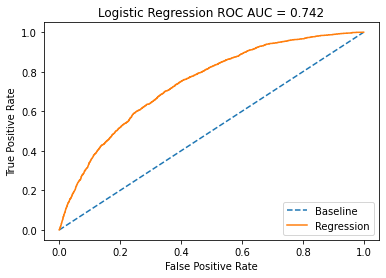

In [71]:
# Обучаем модель логистической регрессии
model_under = LogisticRegression(solver='liblinear', max_iter=5000)
model_under.fit(X_train_under, Y_train_under)

probs_under = model_under.predict_proba(X_valid_under)
Y_pred_under = model_under.predict(X_valid_under)
probs_under = probs_under[:,1]


fpr, tpr, threshold = roc_curve(Y_valid_under, probs_under)
roc_auc = roc_auc_score(Y_valid_under, probs_under)

# Выводим на экран график roc_auc
print_roc_auc(Y_valid_under, probs_under)

In [72]:
confusion_matrix(Y_valid_under, Y_pred_under)

array([[8610, 4323],
       [ 574, 1253]])

In [73]:
# Метрики качества нашей модели
print_metrics(Y_valid_under, Y_pred_under)

balanced_accuracy: 0.6758
precision_score: 0.2247
recall_score: 0.6858
f1_score: 0.3385


У новой модели метрики чуть получше, чем у предыдущей. Её и возьмём за основу для дальнейших исследований.

### Работа с выбранной моделью

С помощью функции GridSearchCV найдём оптимальные гиперпараметры для нашей модели и посмотрим, улучшатся ли метрики

In [74]:
# Выключим предупреждения
import warnings
warnings.filterwarnings("ignore")

model = model_under

iter_ = 50
epsilon_stop = 1e-3

# Создадим список гиперпараметров
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight': [None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'saga'], 
     'class_weight': [None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=12, cv=5)
gridsearch.fit(X_train_under, Y_train_under)
model = gridsearch.best_estimator_

# Печатаем получившиеся наилучшие гиперпараметры
print('Наилучшие гиперпараметры:')
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
# Печатаем метрики с этими наилучшими гиперпараметрами
preds = model.predict(X_valid_under)
y_pred_prob = model.predict_proba(X_valid_under)[:,1]
y_pred = model.predict(X_valid_under)

print('\nПолучившиеся метрики:')
print_metrics(Y_valid_under, y_pred)

Наилучшие гиперпараметры:
	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False

Получившиеся метрики:
balanced_accuracy: 0.6756
precision_score: 0.2247
recall_score: 0.6853
f1_score: 0.3384


Как видим, метрики практически не изменились. Тогда оставим гиперпараметры по умолчанию.

In [75]:
# undersampling для всей тренировочной выборки
train_finish_1 = train_data[train_data['default'] == 1].copy()
count_1 = len(train_finish_1)

train_finish_0 = train_data[train_data['default'] == 0].iloc[:count_1,:].copy()

train_finish = pd.concat([train_finish_1, train_finish_0])

# Проверим количество классов
train_finish['default'].value_counts()

1    9372
0    9372
Name: default, dtype: int64

In [76]:
# Выделим из выборки признаки и целевую переменную
X_train_finish_pd = train_under.drop(['default'], axis=1).copy()
Y_train_finish = train_under['default'].copy().values

In [77]:
# Cтандартизируем числовые признаки
scaler_finish = StandardScaler()
X_train_finish_num = scaler_finish.fit_transform(X_train_finish_pd[num_cols].values)
    
# И соберём все признаки в numpy array
X_train_finish = np.hstack([X_train_finish_num, X_train_finish_pd.drop(columns=num_cols).values])

In [78]:
# Обучим итоговую модель на этих данных
model_finish = LogisticRegression(solver='liblinear', max_iter=5000)
model_finish.fit(X_train_finish, Y_train_finish)

LogisticRegression(max_iter=5000, solver='liblinear')

In [79]:
# Подготовим тестовые данные для работы с моделью

# Удалим столбец default с фиктивными значениями
X_test_pd = test_data.drop(['default'], axis=1)

# Стандартизуем числовые данные по всем данным в тренировочном датасете

X_test_num = scaler_finish.transform(X_test_pd[num_cols].values)

# И соберём все признаки в numpy array
X_test = np.hstack([X_test_num, X_test_pd.drop(columns=num_cols).values])

# Создание файла submission

In [80]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [81]:
Y_sub = model_finish.predict_proba(X_test)
test['default'] = Y_sub[:,1]

In [82]:
submission = test[['client_id','default']]
display(submission.head(10))
display(submission.shape)

,client_id,default
0,74835,0.214057
1,17527,0.778156
2,75683,0.313301
3,26883,0.416034
4,28862,0.135334
5,99881,0.625384
6,26630,0.787564
7,79934,0.178790
8,16605,0.127234
9,105449,0.138884


(36349, 2)

In [83]:
submission.to_csv('submission.csv', index=False)